# <center>Data Analysis 3 - Assignment 2<center>
    
<center>Created by Zsófia Rebeka Katona</center>

Methods to use:
- ols
- tree based method (bagging or boosting)
- can be lasso
- RF or RGB
- the variables may be important
- you can put all the things
- the model selects it itself
- be able to interpret what I'm doing
- even with lasso, I can't select all the variables, all the possible interactions
- first do a RF and based on the VI, the top 10 most important variables -> build a LASSO model
- we have to explain what drives what
- you pick the most important variables
- it gives us e birdseye view on the relationship between the x and y variables
- 

In [1]:
# Importing the required libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
import math

import ast
import seaborn as sns
from plotnine import *

In [2]:
# Importing the prewritten helper functions
from py_helper_functions import *

____________________________________________________________________________________________________________________________
# Data importing

__________________________________________________________________________________________________________________________

In [3]:
# Importing data from github
data = pd.read_csv('https://raw.githubusercontent.com/zsofiarebeka/DA3_Assignment-2/main/Toronto_listings.csv')

In [4]:
# Checking the data
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,24018771,https://www.airbnb.com/rooms/24018771,20240108030557,2024-01-08,city scrape,Home in Toronto · ★4.74 · 1 bedroom · 1 bed · ...,NaN,NaN,https://a0.muscache.com/pictures/1030ee76-f3f7...,179038571,...,4.78,4.77,4.72,STR-2009-FDSXPB,f,3,0,3,0,1.83
1,50680103,https://www.airbnb.com/rooms/50680103,20240108030557,2024-01-08,city scrape,Boat in Toronto · 1 bedroom · 1 bath,NaN,NaN,https://a0.muscache.com/pictures/91f84c43-e010...,396389036,...,NaN,NaN,NaN,Exempt,t,1,1,0,0,NaN
2,1018845223985730763,https://www.airbnb.com/rooms/1018845223985730763,20240108030557,2024-01-08,city scrape,Townhouse in Toronto · ★New · 1 bedroom · 1 be...,NaN,NaN,https://a0.muscache.com/pictures/f1e047ed-949d...,9660032,...,NaN,NaN,NaN,NaN,t,4,1,3,0,NaN
3,842991103042611460,https://www.airbnb.com/rooms/842991103042611460,20240108030557,2024-01-08,city scrape,Bed and breakfast in Toronto · ★4.67 · 1 bedro...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,128444795,...,5.00,5.00,5.00,STR-2011-GTCKVH,f,1,0,1,0,0.51
4,1004965626999219484,https://www.airbnb.com/rooms/1004965626999219484,20240108030557,2024-01-08,city scrape,Home in Toronto · ★4.73 · 1 bedroom · 4 beds ·...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,120551336,...,5.00,4.93,4.80,STR-2310-GYFHHV,f,1,0,1,0,6.92


In [5]:
# Checking out the info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20386 entries, 0 to 20385
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20386 non-null  int64  
 1   listing_url                                   20386 non-null  object 
 2   scrape_id                                     20386 non-null  int64  
 3   last_scraped                                  20386 non-null  object 
 4   source                                        20386 non-null  object 
 5   name                                          20386 non-null  object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         11337 non-null  object 
 8   picture_url                                   20386 non-null  object 
 9   host_id                                       20386 non-null 

In [6]:
data.isna().sum().sum()

238342

__________________________________________________________________________________________________________________________
## Data cleaning

__________________________________________________________________________________________________________________________

In [7]:
# Dropping columns that are not needed
data = data.drop(columns = ["listing_url",
                            "scrape_id",
                            "last_scraped",
                            "name",
                            "description",
                            "neighborhood_overview",
                            "picture_url",
                            "neighbourhood_group_cleansed",
                            "bathrooms",
                            "host_url",
                            "host_location",
                            "host_about",
                            "host_response_time",
                            "host_thumbnail_url",
                            "host_picture_url",
                            "license"
                            ])

__________________________________________________________________________________________________________________________
## Feature Engineering

In [8]:
# Turning the columns with t/f values to binary columns and rename them
binary_columns = ["host_is_superhost",
                  "host_has_profile_pic",
                  "host_identity_verified",
                  "has_availability",
                  "instant_bookable"
                 ]
for col in binary_columns:
    data["d_" + col] = data[col].map({"t": 1, "f": 0})

In [9]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,20376,20377,20378,20379,20380,20381,20382,20383,20384,20385
id,24018771,50680103,1018845223985730763,842991103042611460,1004965626999219484,924249347864823562,51907095,831216233852987034,763116487116827873,14016370,...,34397368,956692825221837999,959412427225907843,662483943929168660,934027064352384246,43740738,14694749,955162189200947880,894406870652307040,616449374883279574
source,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,...,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape,city scrape
host_id,179038571,396389036,9660032,128444795,120551336,224870607,224870607,82569874,137701267,22735639,...,133020435,191972966,485918066,211308395,105247026,349513985,91382765,531113660,514941841,158368655
host_name,Yongmei,Turan,Karly,Yan,Saiharan,Kara,Kara,Gagandeep,Shengyuan,Mandy(Xiuqin),...,Melissa,Lilian,Sayanthan,Dario,Tina,Ma De,Jason,Firoz,Andriy,Norbert
host_since,2018-03-17,2021-04-10,2013-10-27,2017-05-01,2017-03-13,2018-11-08,2018-11-08,2016-07-08,2017-06-29,2014-10-19,...,2017-06-01,2018-05-27,2022-11-01,2018-08-23,2016-11-26,2020-06-10,2016-08-22,2023-08-10,2023-05-15,2017-11-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_host_is_superhost,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
d_host_has_profile_pic,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
d_host_identity_verified,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
d_has_availability,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
# Formatting columns with percentages
for perc in ["host_response_rate", "host_acceptance_rate"]:
    data[perc] = data[perc].replace("%", "", regex=True)
    data[perc] = pd.to_numeric(data[perc], errors="coerce")

In [11]:
# Drop the untransformed binary columns
for col in binary_columns:
    data.drop(columns=[col], inplace=True)

In [12]:
# Coverting time-related columns to datetime type of objects
datetime_columns = ["host_since",
                    "calendar_updated",
                    "calendar_last_scraped",
                    "first_review",
                    "last_review"
                    ]
for col in datetime_columns:
    data[col] = pd.to_datetime(data[col], errors = 'coerce') 

In [13]:
# Cleaning the price column from currency symbols and decimals
data.price = data.price.str.replace("$", "").str.replace(",", "")

# Removing rows with empty strings to be able to convert to float
data = data[data["price"] != ""]

# Turning the price column to float
data["price"] = data["price"].astype(float)

# Rename the price columns
data.rename(columns={"price": "usd_price_day"}, inplace=True)

# Dropping rows where price is missing
data = data.dropna(subset=['usd_price_day'])

In [14]:
# Filtering for small and mid-size apartments hosting 2-6 guests
data = data[(data.accommodates >= 2) & (data.accommodates <= 6)]

#### Property types variable

In [15]:
# Checking the property types and their number
data.property_type.value_counts()

Entire rental unit                    3463
Entire condo                          2776
Private room in home                  2252
Entire home                           2137
Entire guest suite                     616
Private room in rental unit            513
Private room in condo                  238
Private room in townhouse              183
Entire loft                            171
Private room in bungalow               158
Entire townhouse                       158
Entire bungalow                        144
Private room in guest suite            123
Entire guesthouse                       92
Entire serviced apartment               45
Private room in villa                   34
Room in boutique hotel                  28
Private room in bed and breakfast       24
Shared room in home                     22
Shared room in rental unit              21
Private room in guesthouse              17
Room in hotel                           15
Private room                            12
Private roo

In [16]:
# Only keeping the property types if they are small and mid-size apartments
data = data.loc[lambda x: x["property_type"].isin(["Entire rental unit",
                                                   "Entire condo",
                                                   "Private room in home",
                                                   "Entire home",
                                                   "Private room in rental unit",
                                                   "Entire loft",
                                                   "Entire serviced apartment",
                                                   "Entire home/apt",
                                                   "Shared room in rental unit",
                                                   "Shared room in home"
                                                  ])]

In [17]:
# Categorizing the properties to Rental Unit or House catgeories
data['property_type'] = data['property_type'].apply(lambda x: 'Rental Unit' if "rental unit" in x else 'House')

#### Room types and bed variables

In [18]:
# Checking the room types
data.value_counts("room_type")

room_type
Entire home/apt    8596
Private room       2765
Shared room          43
dtype: int64

In [19]:
# Renaming the room types as they are too long
data["room_type"] = data["room_type"].map({"Entire home/apt": "Entire/Apt",
                                          "Private room": "Private",
                                          "Shared room" : 'Shared'})

In [20]:
# Checking the bed types
data.beds.value_counts()

1.0     5473
2.0     3663
3.0     1567
4.0      292
5.0       52
6.0       22
7.0        4
8.0        2
10.0       1
Name: beds, dtype: int64

#### Bathrooms variable

In [21]:
# Checking the bathroom types
data["bathrooms_text"].value_counts()

1 bath               6753
2 baths              1698
1 private bath        912
1 shared bath         863
1.5 baths             529
2.5 baths             191
1.5 shared baths      136
2 shared baths        103
3 baths                98
3.5 baths              50
4 baths                14
3 shared baths         12
Half-bath               7
0 baths                 7
5 baths                 6
2.5 shared baths        6
Shared half-bath        5
0 shared baths          5
4.5 baths               1
5.5 baths               1
8 baths                 1
Private half-bath       1
Name: bathrooms_text, dtype: int64

In [22]:
# Assigning numerical values to bathrooms
data["bathrooms_text"] = data["bathrooms_text"].map({"1 bath": 1,
                                                  "2 baths": 2,
                                                  "1 private bath": 1,
                                                  "1 shared bath": 1,
                                                  "1.5 baths": 1.5,
                                                  "2.5 baths": 2.5,
                                                  "1.5 shared baths": 1.5,
                                                  "2 shared baths": 2,
                                                  "3 baths": 3,
                                                  "3.5 baths": 3.5,
                                                  "4 baths": 4,
                                                  "3 shared baths": 3,
                                                  "0 baths": 0,
                                                  "5 baths": 5,
                                                  "4.5 baths" : 4.5,
                                                  "5.5 baths" : 5.5,
                                                  "8 baths" : 8,
                                                  "Private half-bath" : 0.5
                                                  })

In [23]:
# Renaming the bathrooms_text column to bathrooms
data.rename(columns={"bathrooms_text": "bathrooms"}, inplace = True)

### Pooling values

In [24]:
# Pooling accomodations with 0, 1, 2-10 bathrooms

bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 10)], closed="left")
f_bath = pd.cut(data["bathrooms"].to_list(), bins, labels=["0.0", "1.0", "2.0"])
f_bath.categories = [0, 1, 2]
data["bathrooms"] = f_bath

f_bath.value_counts(dropna=False)

0         8
1      9193
2      2175
NaN      28
dtype: int64

In [25]:
data.number_of_reviews.describe()

count    11404.000000
mean        27.054630
std         56.053766
min          0.000000
25%          0.000000
50%          6.000000
75%         28.000000
max       1018.000000
Name: number_of_reviews, dtype: float64

In [26]:
# Pooling the number of reviews into three categories: none, 1-27 and over 27

bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 27), (27, max(data.number_of_reviews))], closed="left"
)
fnor = pd.cut(data["number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
data["number_of_reviews"] = fnor
data["number_of_reviews"].value_counts(dropna=False)

1      5455
2      3005
0      2943
NaN       1
Name: number_of_reviews, dtype: int64

In [27]:
# Pooling and categorizing the number of minimum nights: 1,2,3 and 3+

bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(data.minimum_nights))], closed="left"
)
f_min_n = pd.cut(data["minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
f_min_n.categories = [1, 2, 3]
data["minimum_nights"] = f_min_n
data["minimum_nights"].value_counts(dropna=False)

3      8504
1      1688
2      1211
NaN       1
Name: minimum_nights, dtype: int64

### Handling missing values

In [28]:
# Transforming the Infinite values with NaNs
data = data.replace([np.inf, -np.inf], np.nan)

In [29]:
# Checking for missing values
to_filter = data.isna().sum()
to_filter[to_filter > 0]

host_response_rate              2392
host_acceptance_rate            1603
host_neighbourhood              7509
neighbourhood                   5041
bathrooms                         28
bedrooms                       11400
beds                             328
minimum_nights                     1
calendar_updated               11404
number_of_reviews                  1
first_review                    2943
last_review                     2943
review_scores_rating            2939
review_scores_accuracy          2940
review_scores_cleanliness       2940
review_scores_checkin           2941
review_scores_communication     2940
review_scores_location          2940
review_scores_value             2940
reviews_per_month               2943
d_host_is_superhost              126
dtype: int64

In [30]:
# In the case of target variable, we have to drop them
data = data.loc[lambda x: x.usd_price_day.notnull()]

# Making sure ther are no NA values in the target variable
data.usd_price_day.isna().value_counts()

False    11404
Name: usd_price_day, dtype: int64

In [31]:
# When there is a few and not that important, we can impute them
data = data.assign(
    host_response_rate=lambda x: x["host_response_rate"].fillna(np.median(x["host_response_rate"].dropna())),
    host_acceptance_rate=lambda x: x["host_acceptance_rate"].fillna(np.median(x["host_acceptance_rate"].dropna())),
    bathrooms=lambda x: x["bathrooms"].fillna(np.median(x["bathrooms"].dropna())),
    beds=lambda x: np.where(x["beds"].isnull(), x["accommodates"], x["beds"]),
    minimum_nights=lambda x: x["minimum_nights"].fillna(1),
    number_of_reviews=lambda x: x["number_of_reviews"].fillna(1)
)

In [32]:
# When there are too many missing values and the column is not that important, we can drop the column
data=data.drop(columns = ["bedrooms",
                "calendar_updated",
                "host_neighbourhood",
                "neighbourhood"])

In [33]:
# Adding flags to the missing values where the variable is important

for var in ["first_review",
            "last_review",
            "review_scores_rating",
            "review_scores_accuracy",
            "review_scores_cleanliness",
            "review_scores_checkin",
            "review_scores_communication",
            "review_scores_location",
            "review_scores_value",
            "reviews_per_month"]:
    missing_values = data[var].isnull().sum()
    data['flag_' + var] = data[var].isnull().astype(int)
    print(f"Number of missing values in {var}: {missing_values}")

Number of missing values in first_review: 2943
Number of missing values in last_review: 2943
Number of missing values in review_scores_rating: 2939
Number of missing values in review_scores_accuracy: 2940
Number of missing values in review_scores_cleanliness: 2940
Number of missing values in review_scores_checkin: 2941
Number of missing values in review_scores_communication: 2940
Number of missing values in review_scores_location: 2940
Number of missing values in review_scores_value: 2940
Number of missing values in reviews_per_month: 2943


In [34]:
# Checking if the flag columns are correct
data.flag_first_review.value_counts()

0    8461
1    2943
Name: flag_first_review, dtype: int64

### Creating numerical values

In [35]:
# Transforming and renaming the numerical columns

numericals = [
    "host_listings_count",
    "host_total_listings_count",
    "accommodates",
    "beds",
    "maximum_nights",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews_ltm",
    "review_scores_rating",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "reviews_per_month"
]

for col in numericals:
    data["n_" + col] = pd.to_numeric(data[col], errors="coerce")

In [36]:
# Drop the untransformed binary columns
for col in numericals:
    data.drop(columns=[col], inplace=True)

### Creating factorial variables

In [37]:
# Renaming columns to factorial

factorials = [
    "room_type",
    "neighbourhood_cleansed",
    "property_type",
    "number_of_reviews",
    "bathrooms",
    "minimum_nights"
]

for col in factorials:
    data.rename(columns={col: "f_" + col}, inplace=True)

__________________________________________________________________
# EDA
__________________________________________________________________

In [38]:
# Checking out the total number of NA values left
data.isna().sum().sum()

29535

#### Discovering the price variable

In [39]:
# Checking the basic metrics for price
data.usd_price_day.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).map('{:,.1f}'.format)

count    11,404.0
mean        181.2
std         342.9
min           8.0
1%           34.0
10%          60.0
25%          87.0
50%         130.0
75%         200.0
90%         299.0
95%         396.0
99%         898.9
max      12,400.0
Name: usd_price_day, dtype: object

In [40]:
# Drop extreme values
data = data[data['usd_price_day'] <= 300]

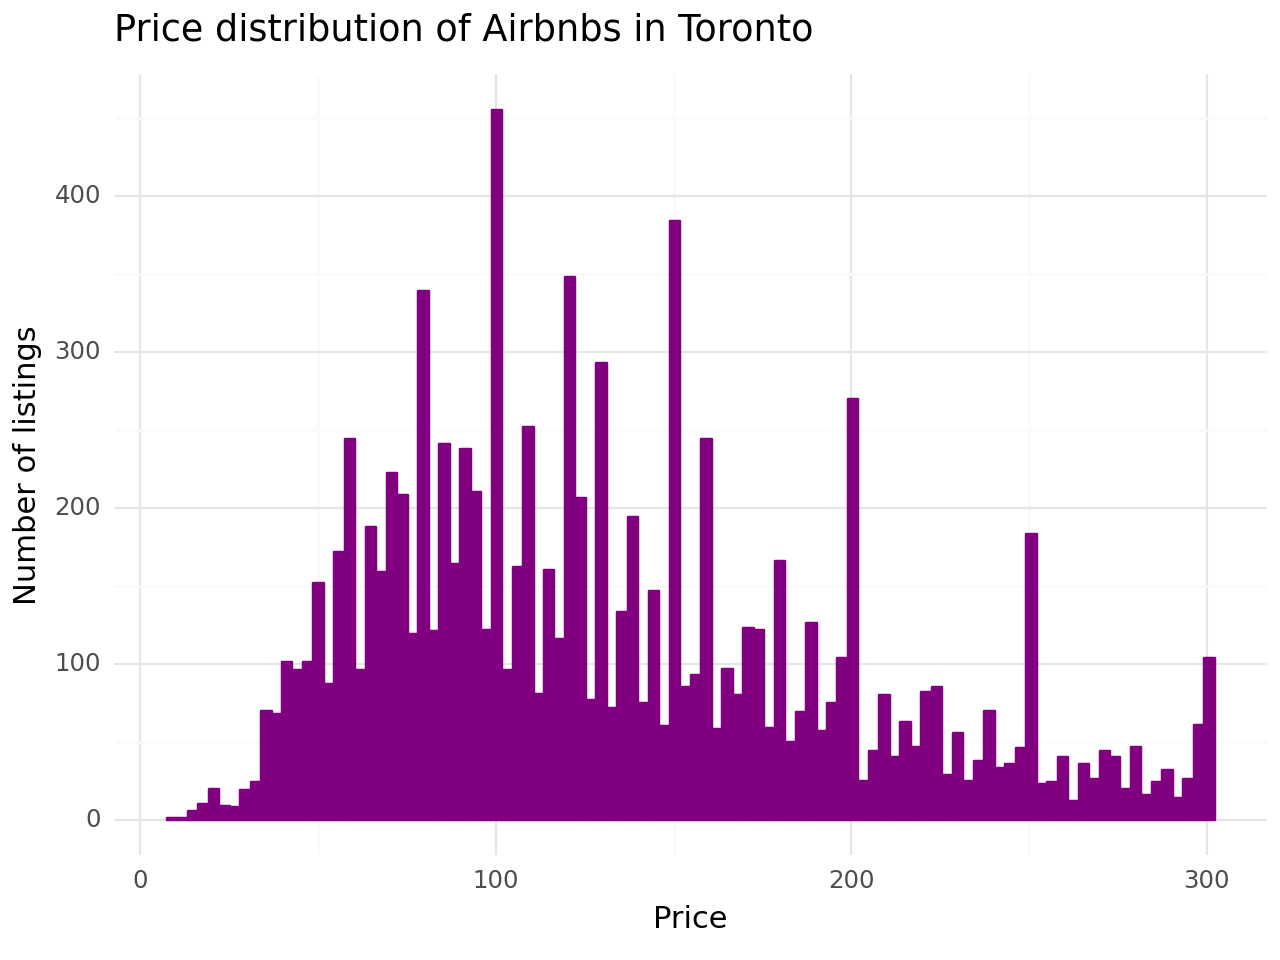

<Figure Size: (640 x 480)>

In [41]:
# Checking the distribution of airbnb prices
ggplot(data, aes(x='usd_price_day')) + \
    geom_histogram(fill='purple', color='purple', bins=100) + \
    theme_minimal() + \
    ggtitle('Price distribution of Airbnbs in Toronto') + \
    xlab('Price') + \
    ylab('Number of listings') 

In [42]:
# Checking the distribution of hourly wages
ax = sns.histplot(data, x='usd_price_day', stat='density')
sns.kdeplot(data, x='usd_price_day', color="red")

ax.yaxis.set_visible(False)
plt.title('Distribution of prices (in USD)')
plt.xlabel('Price')
plt.ylabel('Number of listings');

In [43]:
# Taking a look at the average price by property and room type
data.groupby(["f_property_type", "f_room_type"]).agg(mean_price=("usd_price_day", np.mean))

mean_price
f_property_type f_room_type            
House           Entire/Apt   156.060394
                Private       82.692204
                Shared        95.476190
Rental Unit     Entire/Apt   144.276187
                Private       97.723658
                Shared        75.950000

______________________________________________________________
# Modelling

____________________________________________________________________________


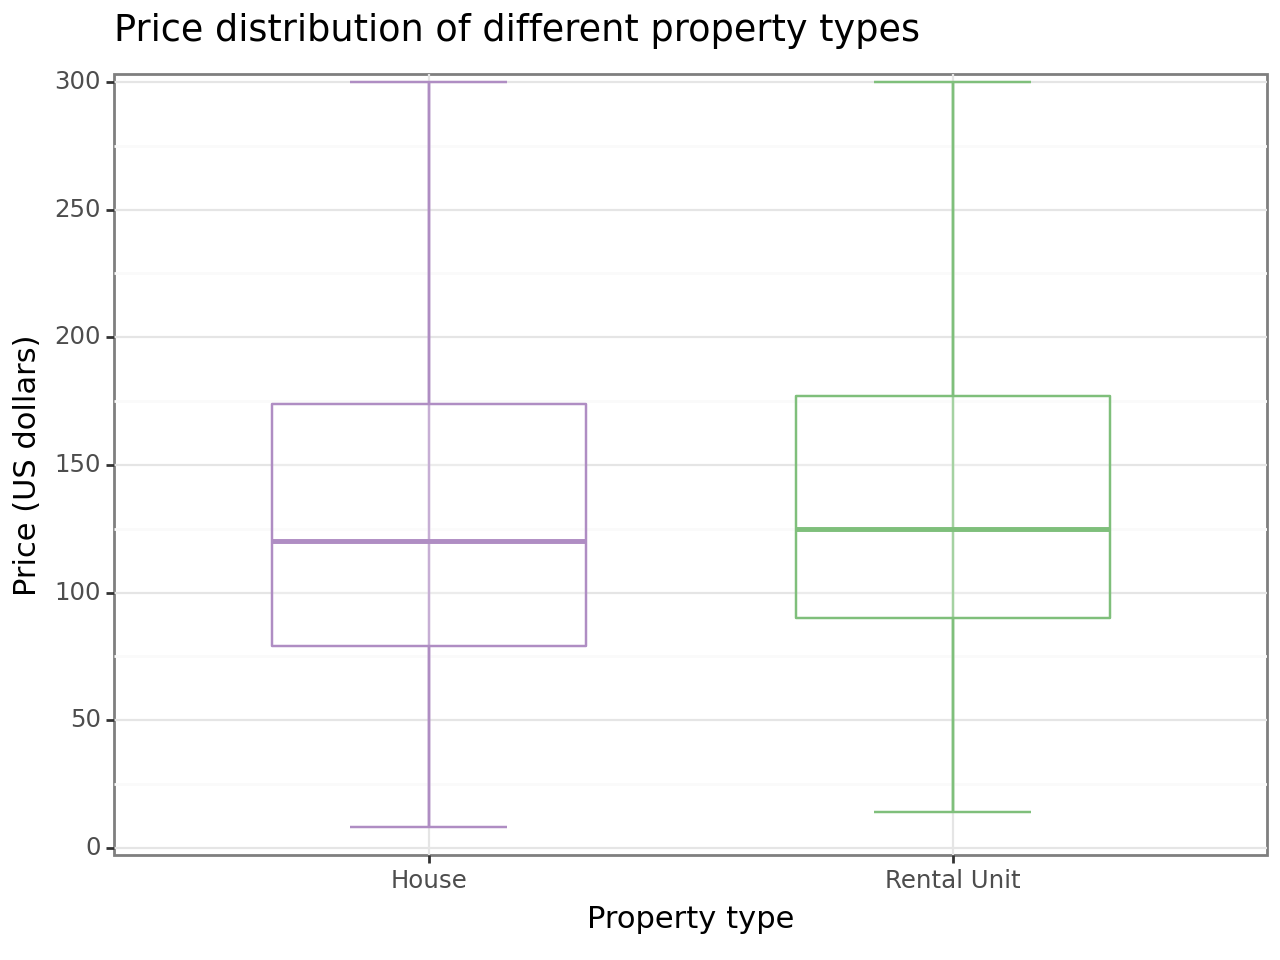

<Figure Size: (640 x 480)>

In [129]:
# Creating a box plot groupped by property types
(
    ggplot(data, aes(x="f_property_type", y="usd_price_day"))
    + stat_boxplot(
        aes(group="f_property_type"),
        geom="errorbar",
        width=0.3,
        color=('#af8dc3', "#7fbf7b"),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group="f_property_type"),
        color=('#af8dc3', "#7fbf7b"),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_shape="",
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=seq(0, 301, 50))
    + labs(x="Property type", y="Price (US dollars)",
          title = "Price distribution of different property types")
    + theme_bw()
)

In [117]:
# Checking the price range to see actual numbers
data.usd_price_day.describe()

count    10376.000000
mean       133.562548
std         64.807755
min          8.000000
25%         83.000000
50%        120.000000
75%        175.000000
max        300.000000
Name: usd_price_day, dtype: float64

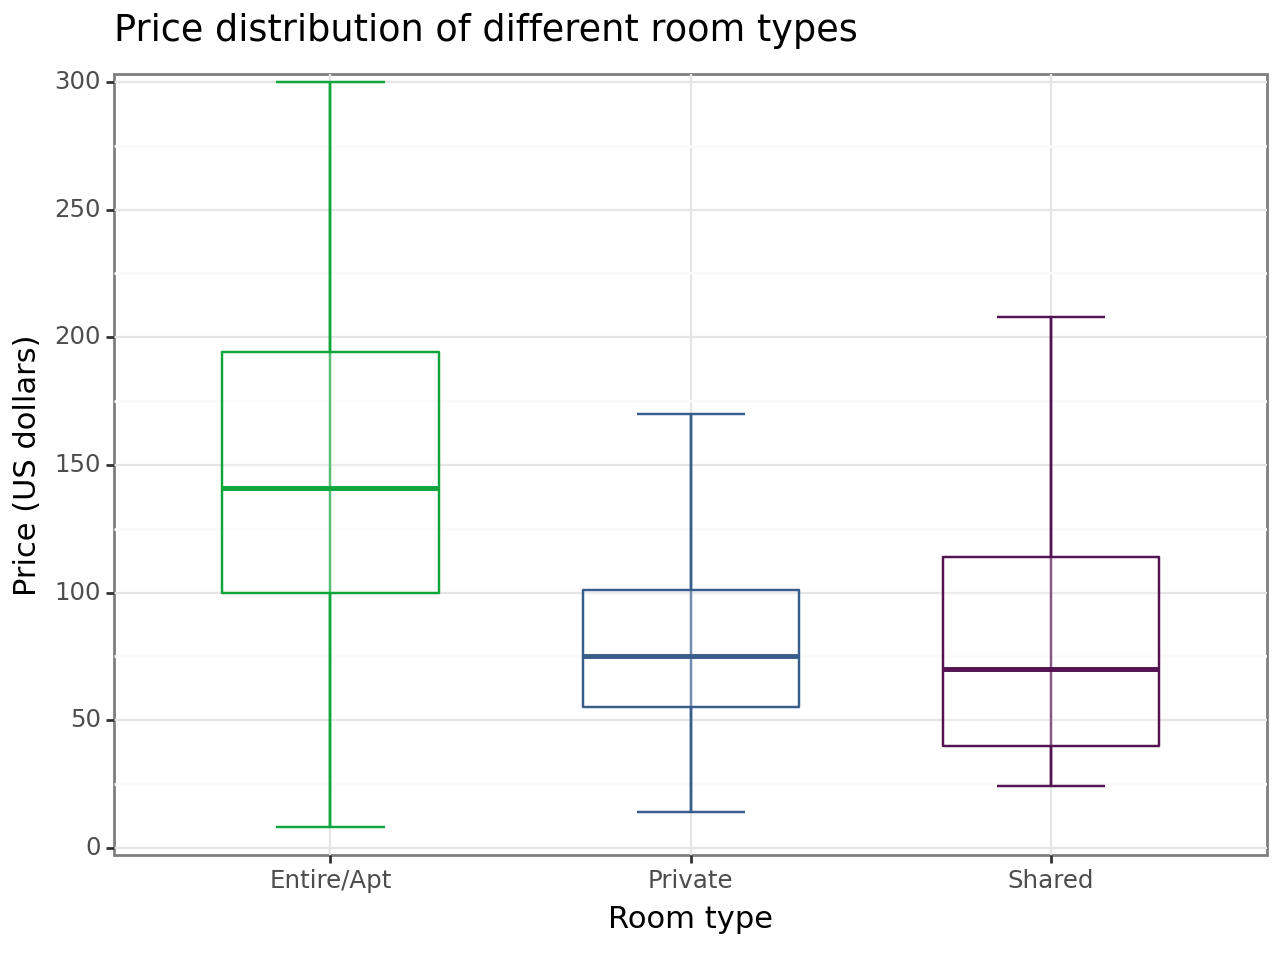

<Figure Size: (640 x 480)>

In [128]:
# Creating a box plot groupped by room types
(
    ggplot(data, aes(x="f_room_type", y="usd_price_day"))
    + stat_boxplot(
        aes(group="f_room_type"),
        geom="errorbar",
        width=0.3,
        color=(color[1], color[0], color[2]),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group="f_room_type"),
        color=(color[1], color[0], color[2]),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_shape="",
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=seq(0, 301, 50))
    + labs(x="Room type", y="Price (US dollars)",
          title = "Price distribution of different room types")
    + theme_bw()
)

In [ ]:
price_diff_by_variables(
    listings,
    "room_type",
    "property_type",
    "Room Type",
    "Property Type",
)

In [47]:
# We have to consider that there is a marginal value for shared room type
data.f_room_type.value_counts()

Entire/Apt    7600
Private       2735
Shared          41
Name: f_room_type, dtype: int64

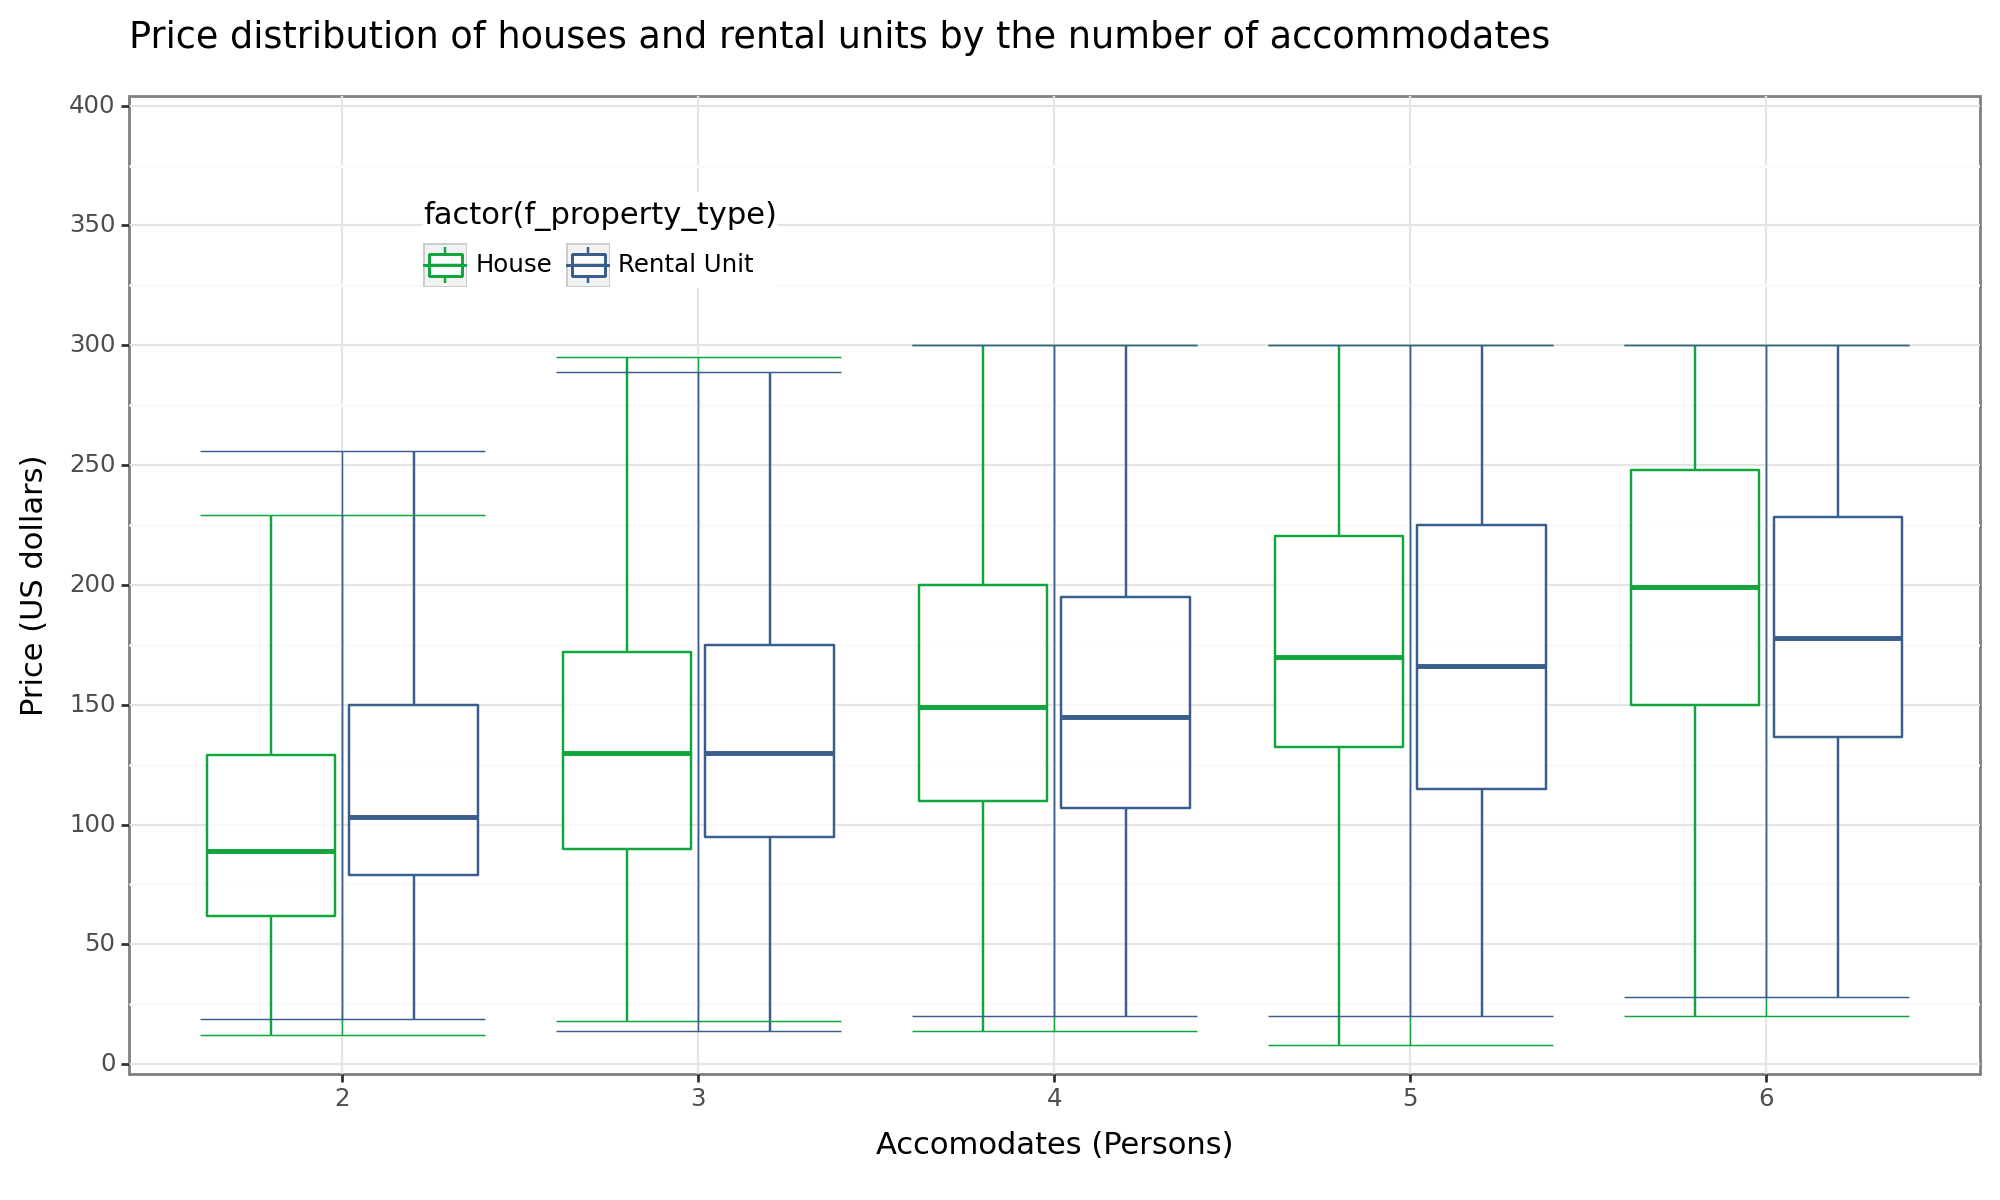

<Figure Size: (1000 x 600)>

In [130]:
# Looking at the prices based on the number of accommodates
(
    ggplot(
        data,
        aes(
            x="factor(n_accommodates)",
            y="usd_price_day",
            color="factor(f_property_type)",
        ),
        
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape="", width=0.8, stat="boxplot")
    + stat_boxplot(geom="errorbar", width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_fill_manual(name="", values=(color[1], color[0]))
    + labs(x="Accomodates (Persons)", y="Price (US dollars)",
          title = "Price distribution of houses and rental units by the number of accommodates")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8), figure_size=(10, 6))
)

__________________________________________________________________
# 1. Model: OLS
__________________________________________________________________

#### Model 1. Regression of price on number of accommodates
$price=\beta_0 + \beta_1 accommodates$

In [49]:
# Creating the regression for Model 1
reg1 = smf.ols(formula="usd_price_day~n_accommodates", data=data).fit(cov_type="HC1")

## Linear (OLS) vs  Non-linear (Lowess)

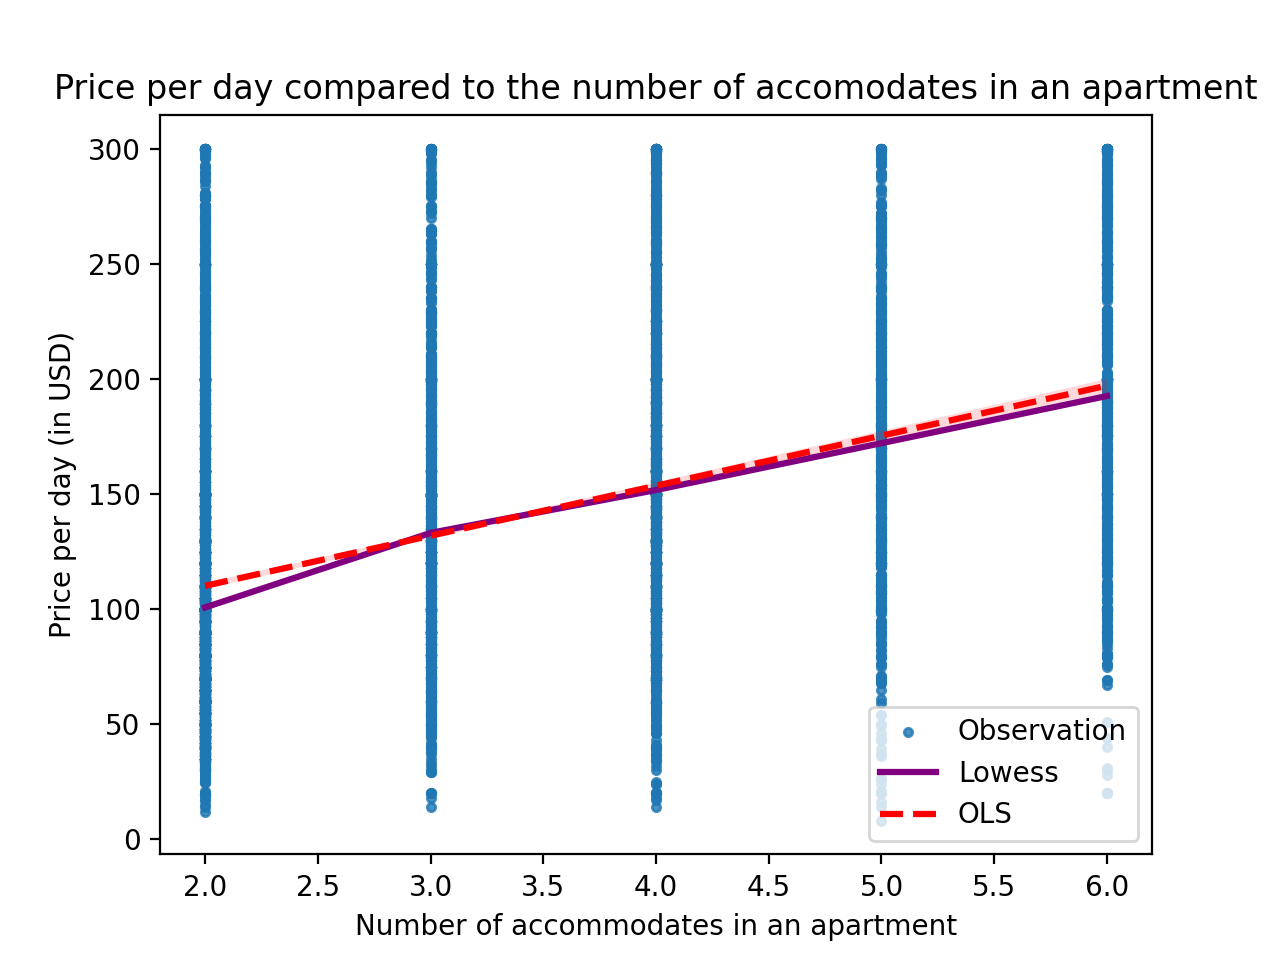

In [50]:
# Plotting the OLS and Lowess models
sns.regplot(data, x = 'n_accommodates', y = 'usd_price_day', marker= '.', fit_reg= True, lowess= True, line_kws = {'color':'purple'})

# OLS
sns.regplot(data, x = 'n_accommodates', y = 'usd_price_day', scatter=False, line_kws={'color':'red', 'linestyle': '--'})

plt.title("Price per day compared to the number of accomodates in an apartment")
plt.xlabel('Number of accommodates in an apartment')
plt.ylabel('Price per day (in USD)')
plt.legend(['Observation', 'Lowess', 'OLS'])

plt.show()


The OLS and the Lowess plots are quite similar, therefore the linear model could easily find a good fit.

## Further models

#### Model 2. M1 + room types, property types, bathrooms, bedrooms, number of reviews

#### Model 3. M2 + neighbourhood cleansed

#### Model 4. M3 + several basic variables interactions

In [51]:
# Creating the regressions
reg2 = smf.ols(formula="usd_price_day~n_accommodates + f_room_type + f_property_type + f_bathrooms + n_beds + f_number_of_reviews", data=data).fit(cov_type="HC1")
reg3 = smf.ols(formula="usd_price_day~n_accommodates + f_room_type + f_property_type + f_bathrooms + n_beds + f_number_of_reviews + f_neighbourhood_cleansed", data=data).fit(cov_type="HC1")
reg4 = smf.ols(formula="usd_price_day~n_accommodates + f_room_type + f_property_type + f_neighbourhood_cleansed + f_bathrooms + n_beds + f_number_of_reviews + f_room_type*f_property_type + n_accommodates*f_property_type + f_room_type*d_has_availability + f_bathrooms*f_property_type + f_neighbourhood_cleansed*f_property_type + d_instant_bookable*f_minimum_nights", data=data).fit(cov_type="HC1")

In [133]:
# Viewing regression results with stargazer
sg = stargazer.Stargazer([reg1, reg2, reg3, reg4])
covariate_order = ["n_accommodates","f_room_type[T.Private]", "f_room_type[T.Shared]", "f_property_type[T.Rental Unit]",
                    "f_bathrooms[T.1]", "f_bathrooms[T.2]", "n_beds",
                   "f_number_of_reviews[T.1]", "f_number_of_reviews[T.2]", "Intercept"]

# Set covariate order
sg.covariate_order(covariate_order)

# Rename covariates
sg.rename_covariates({"n_accommodates": "Accommodates", 
                      "f_room_type[T.Private]": "Private Room Type", 
                      "f_room_type[T.Shared]": "Shared Room Type", 
                      "f_property_type[T.Rental Unit]": "Rental Unit",
                      "f_bathrooms[T.1]" : "Bathrooms (1)",
                      "f_bathrooms[T.2]" : "Bathrooms (2-10)",
                      "n_beds" : "Beds",
                      "f_number_of_reviews[T.1]" : "Number of reviews (<27)",
                      "f_number_of_reviews[T.2]" : "Number of reviews (27<)",
                      "Intercept": "Constant"})

# Adding RMSE for measurement in the full sample for each model
rmse_values = [round(rmse(x.fittedvalues, data.usd_price_day), 3) for x in [reg1, reg2, reg3, reg4]]
sg.add_line('RMSE', rmse_values, location=stargazer.LineLocation.FOOTER_BOTTOM)

# Adding BIC for measurement in the full sample for each model
bic = [round(x.bic, 2) for x in [reg1, reg2, reg3, reg4]]
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)

# Display Stargazer table
sg

Comparing the first regression to the other models, it becomes visible that room types have a greater impact on the target variable. The $R^2$ values of the models increase gradually (from 0.183 to 0.391).

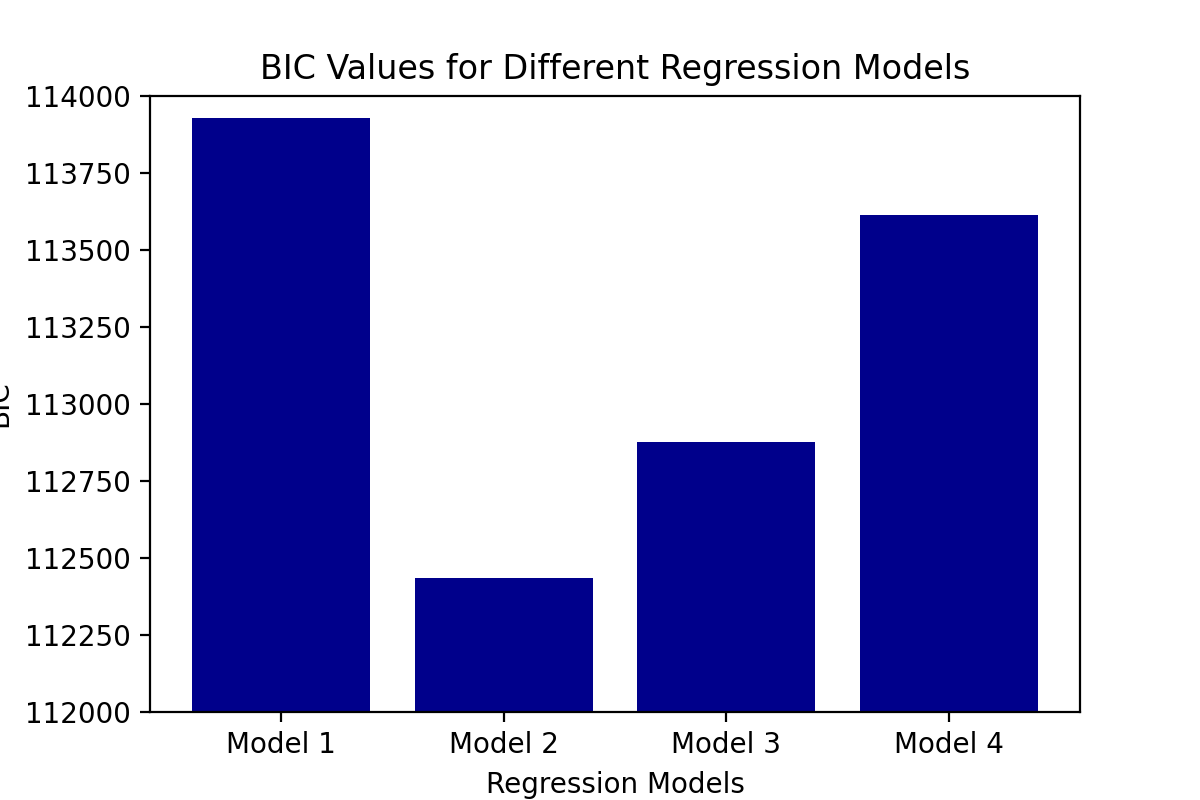

In [134]:
# Plotting a bar chart to visualize the differences in BIC scores
bic_values = [reg1.bic, reg2.bic, reg3.bic, reg4.bic]

# Model names as labels
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Customizing the bar chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, bic_values, color='darkblue')

# Adjusting and giving a limited interval for the y axis to see the slight differences between the scores
plt.ylim(112000, 114000)
plt.title('BIC Values for Different Regression Models')
plt.xlabel('Regression Models')
plt.ylabel('BIC')
plt.show()

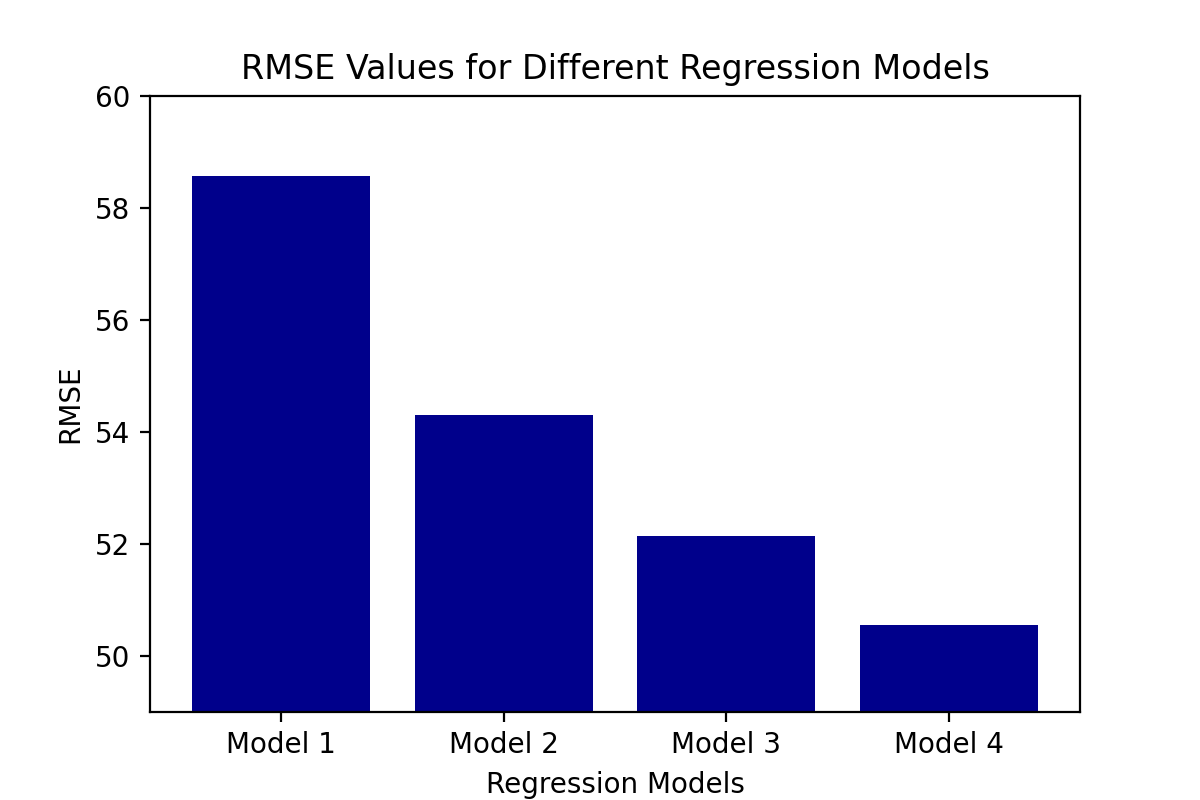

In [137]:
# Plotting a bar chart to visualize the differences in RMSE scores
rmse_values = [rmse(reg1.fittedvalues,data.usd_price_day),
               rmse(reg2.fittedvalues,data.usd_price_day),
               rmse(reg3.fittedvalues,data.usd_price_day),
               rmse(reg4.fittedvalues,data.usd_price_day)]

# Model names as labels
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Customizing the bar chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, rmse_values, color='darkblue')

# Adjusting and giving a limited interval for the y axis to see the slight differences between the scores
plt.ylim(49, 60)
plt.title('RMSE Values for Different Regression Models')
plt.xlabel('Regression Models')
plt.ylabel('RMSE')
plt.show()

Despite the high BIC values moving around 113000, the RMSE of the models ranged between 50 and 59, with Model 4 fitting the data best among all the four models (50.559).

__________________________________________________________________
# 2. Model: LASSO
__________________________________________________________________

In [55]:
# Defining variables

data['n_accommodates2'] = data['n_accommodates']**2
data['n_beds2'] = data['n_beds']**2
data['n_beds3'] = data['n_beds']**3

basic_lev = (
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
)
basic_add = ("f_bathrooms", "f_minimum_nights")
reviews = ("f_number_of_reviews", "n_review_scores_rating")
poly_lev = ("n_accommodates2", "n_beds2", "n_beds3")

#### Interactions

In [56]:
#######################

#### Regressions with cross-validation

In [57]:
# Defining different sets of features
X1 = ("f_room_type*f_property_type", "f_room_type*d_host_is_superhost")
X2 = ("d_instant_bookable*f_property_type", "d_has_availability*f_property_type", "d_host_is_superhost*f_property_type")
X3 = ("(f_property_type + f_room_type + f_minimum_nights + n_beds)*d_host_is_superhost")

In [58]:
# Creating 8 different models
modellev1="~ n_accommodates"
modellev2="~"+"+".join(basic_lev)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)
modellev5="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)
modellev6="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)
modellev7="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)
modellev8="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+X3

In [59]:
# Calculating the sample size
smp_size = round(0.2 * data.shape[0])-1
smp_size

2074

In [60]:
# Set the seed to make results reproducable
np.random.seed(20240115)

In [61]:
# Splitting the train and hold out set
data_work,data_holdout=train_test_split(data, test_size=smp_size)

In [62]:
# Checking the shape of the sets
print(data_work.shape)
print(data_holdout.shape)

(8302, 68)
(2074, 68)


In [63]:
# Setting the n folds to 5 
n_folds=5

In [64]:
# Splitting the data into 4 categories, assuming that the data is randomly ordered
k = KFold(n_splits=4, shuffle=False, random_state=None)

In [65]:
def cv_reg(formula, data, kfold, testdata, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold
    
    for train_index, test_index in k.split(data):
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["usd_price_day"], model.predict(data_train)],
            axis=1,
            keys=["usd_price_day", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["usd_price_day"], model.predict(data_test)],
            axis=1,
            keys=["usd_price_day", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["usd_price_day"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["usd_price_day"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    # We return a dictionary with the 
    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }

# Summarize method --> gives us a df
def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [66]:
# Performing cross-validated linear regressions with cov.type = HC0
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [cv_reg("usd_price_day" + i, data, k, "HC0")]

In [67]:
# Summarizing the cross-validation results
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Fold1,59.019909,55.277836,53.825673,53.807415,53.634144,53.598790,53.598790,53.577470
Fold2,58.445551,54.495450,53.175291,53.155809,53.095741,53.080285,53.080285,53.008633
Fold3,58.007776,54.323493,52.933759,52.921403,52.701288,52.686573,52.686573,52.615633
Fold4,58.769452,54.593604,53.351122,53.340250,53.319737,53.300369,53.300369,53.218309
Average,58.560672,54.672596,53.321461,53.306219,53.187728,53.166504,53.166504,53.105011


In [68]:
# Creating a DataFrame for the RMSE values of the train and the test set
rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

In [69]:
rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,58.560672,2
1,5,RMSE Training,54.672596,6
2,12,RMSE Training,53.321461,13
3,15,RMSE Training,53.306219,16
4,20,RMSE Training,53.187728,21
5,25,RMSE Training,53.166504,26
6,25,RMSE Training,53.166504,26
7,28,RMSE Training,53.105011,29
8,1,RMSE Test,58.583176,2
9,5,RMSE Test,54.726030,6


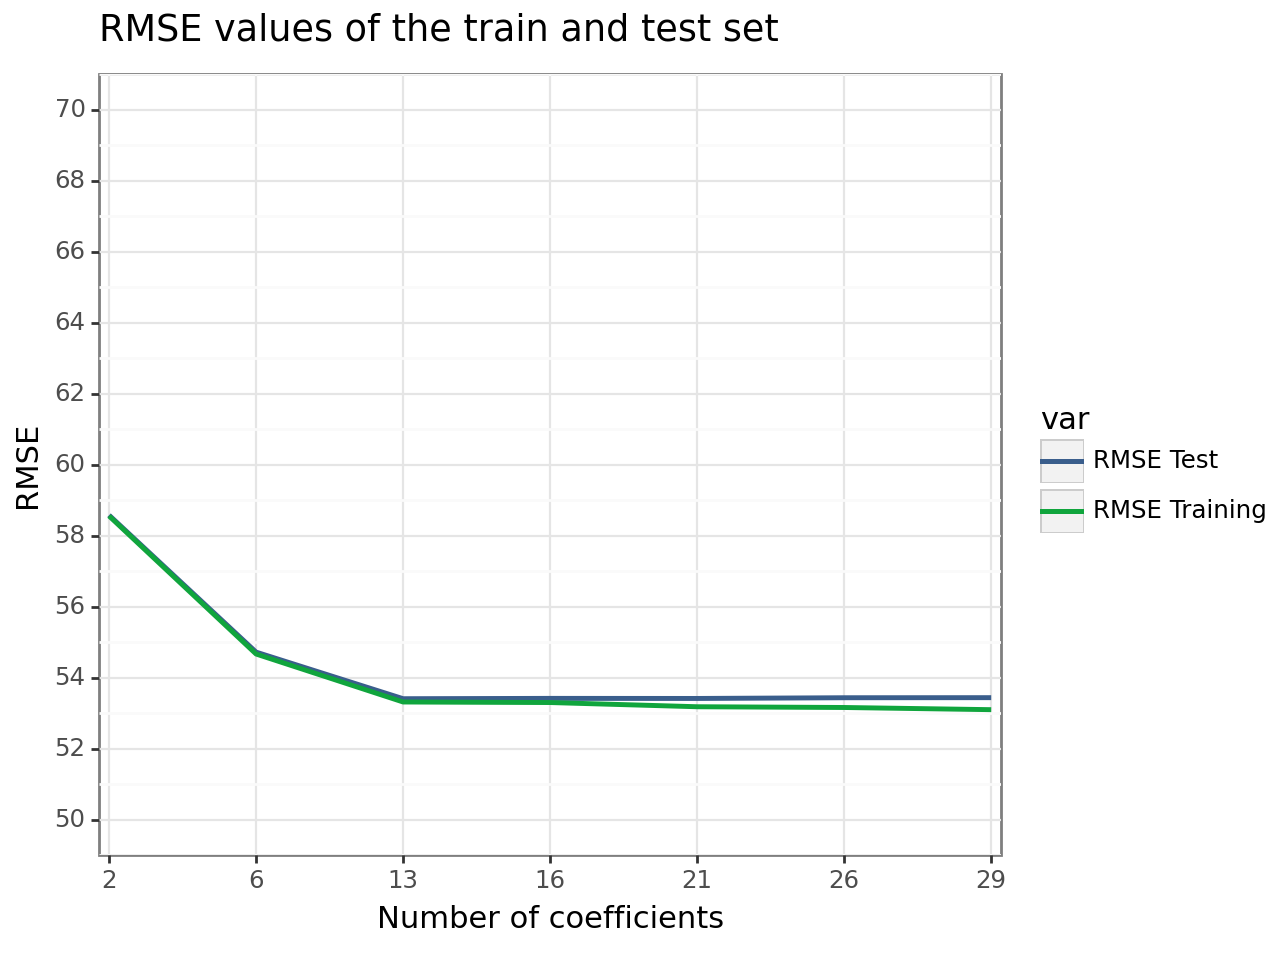

<Figure Size: (640 x 480)>

In [138]:
# Visualizing the RMSE values of the train and the test set
(
    ggplot(rmse_levels, aes(x="factor(nvars2)", y="value", color="var", group="var"))
    + geom_line(size=1, show_legend=True, na_rm=True)
    + scale_color_manual(name="", values=(color[0], color[1]))
    + scale_y_continuous(name="RMSE", limits=(50, 70), breaks=seq(50, 70, 2))
    + scale_x_discrete(
        name="Number of coefficients",
        expand=(0.01, 0.01)
    )
        + labs(title = "RMSE values of the train and test set")
    + theme_bw()
)

The RMSE values of the train and the test set seem to align and go in the same direction, suggesting that the model is not overfitting and the model is generalizing well to unseen data. The RMSE values of the test set suggest that the model is improving in its predictive power, but there is a slight split when the number of coefficients reaches 18. Despite the good performance, further analysis and evaluation are needed to determine the best model for the specific context and requirements.

#### Doing LASSO in another way to check out lambda values

In [71]:
# Defining the model evaluation method and splitting the dataset into 5 folds
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("usd_price_day" + modellev8, data)

In [72]:
# Scaling the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Preparing for Ridge regression with cross-validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

# Defining a range of lambda values
lambdas = [i/100 for i in range(5, 100,5)]

# Creating arrays to store R-squared values
train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [73]:
import datetime
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    reg = Lasso(alpha = i, random_state= 20240211)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2024-02-10 18:31:37
Run:  1, lambda: 0.10, start: 2024-02-10 18:31:37
Run:  2, lambda: 0.15, start: 2024-02-10 18:31:38
Run:  3, lambda: 0.20, start: 2024-02-10 18:31:38
Run:  4, lambda: 0.25, start: 2024-02-10 18:31:38
Run:  5, lambda: 0.30, start: 2024-02-10 18:31:38
Run:  6, lambda: 0.35, start: 2024-02-10 18:31:39
Run:  7, lambda: 0.40, start: 2024-02-10 18:31:39
Run:  8, lambda: 0.45, start: 2024-02-10 18:31:39
Run:  9, lambda: 0.50, start: 2024-02-10 18:31:39
Run: 10, lambda: 0.55, start: 2024-02-10 18:31:39
Run: 11, lambda: 0.60, start: 2024-02-10 18:31:40
Run: 12, lambda: 0.65, start: 2024-02-10 18:31:40
Run: 13, lambda: 0.70, start: 2024-02-10 18:31:40
Run: 14, lambda: 0.75, start: 2024-02-10 18:31:41
Run: 15, lambda: 0.80, start: 2024-02-10 18:31:41
Run: 16, lambda: 0.85, start: 2024-02-10 18:31:41
Run: 17, lambda: 0.90, start: 2024-02-10 18:31:41
Run: 18, lambda: 0.95, start: 2024-02-10 18:31:42


In [74]:
# Melting the R-squared data into a DataFrame
r_squared_data = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [75]:
# Transforming the variables into categorical and reordering
r_squared_data["variable"] = r_squared_data["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [76]:
r_squared_data

,lambda,variable,value
0,0.05,$R^2$ Test set,0.323253
1,0.10,$R^2$ Test set,0.322944
2,0.15,$R^2$ Test set,0.322738
3,0.20,$R^2$ Test set,0.322515
4,0.25,$R^2$ Test set,0.322246
5,0.30,$R^2$ Test set,0.322269
6,0.35,$R^2$ Test set,0.322315
7,0.40,$R^2$ Test set,0.322312
8,0.45,$R^2$ Test set,0.322287
9,0.50,$R^2$ Test set,0.322275


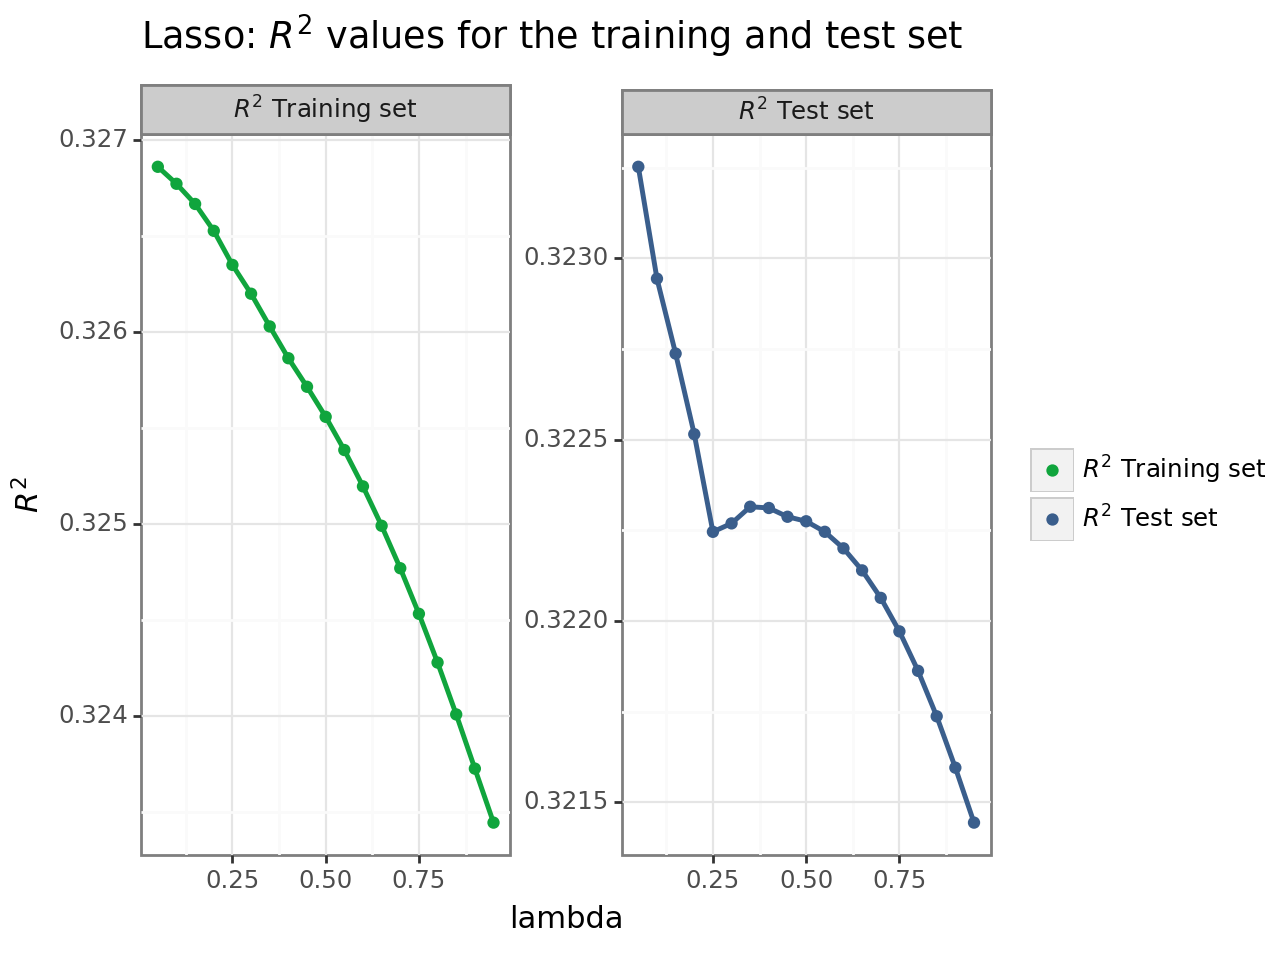

<Figure Size: (640 x 480)>

In [139]:
# Plotting the R2 results
(
    ggplot(r_squared_data, aes(x="lambda", y="value", color="variable"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="$R^2$")
    + facet_wrap("variable", scales="free")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
    + labs(title = 'Lasso: $R^2$ values for the training and test set')
)

Separating the $R^2$ values gave us another perspective on fit and model performance. Similar to the other LASSO results, the values indicate that the model is fitting well to both data sets. The values for the training set are consistently higher, suggesting that the model might be overfitting to some extent, as it performs better on the data it was trained on compared to the unseen data. The $R^2$ values of the test set are the highest when lambda equals to 0.05 and the values decrease gradually as lambda increases, suggesting that a lower lambda value might be more optimal.

__________________________________________________________________
# 3. Model: Random Forest
__________________________________________________________________

In [78]:
# Setting the train and hold out set
data_train, data_holdout = train_test_split( data, train_size=0.7, random_state=42)

In [79]:
# Checking the shape of the train set and hold out set
data_train.shape, data_holdout.shape

((7263, 68), (3113, 68))

In [80]:
# Creating a list for basic variables
basic_vars = [
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "f_bathrooms",
    "f_minimum_nights",
    "n_maximum_nights",
    "f_neighbourhood_cleansed",
]

# Creating a list for reviews variables
reviews = [
    "f_number_of_reviews",
    "n_review_scores_rating",
    "n_reviews_per_month",
]

# Creating amenities from the dummy variables
amenities = [col for col in data if col.startswith("d_")]

In [81]:
amenities

['d_host_is_superhost',
 'd_host_has_profile_pic',
 'd_host_identity_verified',
 'd_has_availability',
 'd_instant_bookable']

In [82]:
# Creating interactions for LASSO
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_has_availability",
    "f_bathrooms:f_property_type",
    "f_neighbourhood_cleansed:f_property_type",
    "d_instant_bookable:f_minimum_nights",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [83]:
# Creating different predictors, including the basic variables, amenities and the interaction terms
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

In [84]:
# Creating the design matrices that represents the predictors_2 and the target variable in a structured format
y, X = dmatrices("usd_price_day ~ " + " + ".join(predictors_2), data_train)

In [85]:
X

DesignMatrix with shape (5319, 159)
  Columns:
    ['Intercept',
     'f_property_type[T.Rental Unit]',
     'f_room_type[T.Private]',
     'f_room_type[T.Shared]',
     'f_bathrooms[T.1]',
     'f_bathrooms[T.2]',
     'f_minimum_nights[T.2]',
     'f_minimum_nights[T.3]',
     'f_neighbourhood_cleansed[T.Agincourt South-Malvern West]',
     'f_neighbourhood_cleansed[T.Alderwood]',
     'f_neighbourhood_cleansed[T.Annex]',
     'f_neighbourhood_cleansed[T.Banbury-Don Mills]',
     'f_neighbourhood_cleansed[T.Bathurst Manor]',
     'f_neighbourhood_cleansed[T.Bay Street Corridor]',
     'f_neighbourhood_cleansed[T.Bayview Village]',
     'f_neighbourhood_cleansed[T.Bayview Woods-Steeles]',
     'f_neighbourhood_cleansed[T.Bedford Park-Nortown]',
     'f_neighbourhood_cleansed[T.Beechborough-Greenbrook]',
     'f_neighbourhood_cleansed[T.Bendale]',
     'f_neighbourhood_cleansed[T.Birchcliffe-Cliffside]',
     'f_neighbourhood_cleansed[T.Black Creek]',
     'f_neighbourhood_cleansed[T.B

In [86]:
X.design_info.column_names

['Intercept',
 'f_property_type[T.Rental Unit]',
 'f_room_type[T.Private]',
 'f_room_type[T.Shared]',
 'f_bathrooms[T.1]',
 'f_bathrooms[T.2]',
 'f_minimum_nights[T.2]',
 'f_minimum_nights[T.3]',
 'f_neighbourhood_cleansed[T.Agincourt South-Malvern West]',
 'f_neighbourhood_cleansed[T.Alderwood]',
 'f_neighbourhood_cleansed[T.Annex]',
 'f_neighbourhood_cleansed[T.Banbury-Don Mills]',
 'f_neighbourhood_cleansed[T.Bathurst Manor]',
 'f_neighbourhood_cleansed[T.Bay Street Corridor]',
 'f_neighbourhood_cleansed[T.Bayview Village]',
 'f_neighbourhood_cleansed[T.Bayview Woods-Steeles]',
 'f_neighbourhood_cleansed[T.Bedford Park-Nortown]',
 'f_neighbourhood_cleansed[T.Beechborough-Greenbrook]',
 'f_neighbourhood_cleansed[T.Bendale]',
 'f_neighbourhood_cleansed[T.Birchcliffe-Cliffside]',
 'f_neighbourhood_cleansed[T.Black Creek]',
 'f_neighbourhood_cleansed[T.Blake-Jones]',
 'f_neighbourhood_cleansed[T.Briar Hill-Belgravia]',
 'f_neighbourhood_cleansed[T.Bridle Path-Sunnybrook-York Mills]',
 '

In [87]:
np.asarray(X)

array([[1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.]])

In [88]:
# Calculating the optimal number of variables (the square root of the number of variables we obtain)
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 12.61.


In [89]:
# Checking the shape of the X matrice
X.shape

(5319, 159)

In [90]:
type(y)

patsy.design_info.DesignMatrix

In [91]:
# Checking the shape of the y matrice
y.shape

(5319, 1)

In [92]:
# Transforming y to one-dimensional to make it compatible for the modeling algorithm
y.ravel().shape

(5319,)

In [93]:
# Creating a GridSearch
rfr = RandomForestRegressor(random_state = 20240211)

In [94]:
# Searching for every potential parameter
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [95]:
# Using GridSearch to tune hyperparameters of an estimator and find the best combination of parameter values
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [96]:
%%time

# Triggering the GridSearch process
# Evaluating different combinations of hyperparameters using CV
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-55.949 total time=   0.4s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-54.475 total time=   0.5s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-53.711 total time=   0.5s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-53.449 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-56.230 total time=   0.3s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-58.233 total time=   0.2s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-57.062 total time=   0.2s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-55.696 total time=   0.2s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-55.683 total time=   0.2s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-58.178 total time=   0.2s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-59.763 total time=   0.1s
[CV 2/5] END max_fea

In [97]:
# Getting the cross-valudates results
rf_model.cv_results_

{'mean_fit_time': array([0.48350949, 0.28485026, 0.22859159, 0.39815645, 0.31239309,
        0.26391726, 0.60760484, 0.41157694, 0.33052373, 0.53197737,
        0.43543711, 0.38817568]),
 'std_fit_time': array([0.06268753, 0.01042523, 0.01160692, 0.00850389, 0.00907119,
        0.00448343, 0.13761972, 0.0467496 , 0.01938   , 0.03104949,
        0.02706941, 0.01688117]),
 'mean_score_time': array([0.02932901, 0.01516075, 0.01555681, 0.02053981, 0.01493912,
        0.01375532, 0.02614355, 0.01814532, 0.01875081, 0.02155056,
        0.01854362, 0.01834364]),
 'std_score_time': array([6.13912702e-03, 9.84584230e-04, 2.40955267e-03, 3.41767400e-03,
        1.73403588e-05, 7.48471027e-04, 6.88874863e-03, 2.38816993e-03,
        6.65731252e-03, 3.24670154e-03, 4.70765374e-03, 3.25751198e-03]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, 

In [98]:
# Placing the cross-validated results into a DataFrame
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [99]:
# Renaming the columns
df_rf_model_cv_results.columns = ['Max features', 'Min node size', 'RMSE']

In [100]:
# Checking the RMSE of the cv results
df_rf_model_cv_results

,Max features,Min node size,RMSE
0,6,5,-54.762708
1,6,10,-56.970456
2,6,15,-58.551286
3,8,5,-53.705612
4,8,10,-55.439166
5,8,15,-56.842103
6,10,5,-52.889493
7,10,10,-54.517035
8,10,15,-55.514095
9,12,5,-52.388687


In [101]:
# Reshaping the DataFrame and rounding the values
df_rf_model_cv_results.pivot(
    index = "Max features",
    columns = "Min node size",
    values = "RMSE").round(2)*-1

Min node size,5,10,15
Max features,,,
6,54.76,56.97,58.55
8,53.71,55.44,56.84
10,52.89,54.52,55.51
12,52.39,53.70,54.58


In [102]:
# Filtering for the best score with scikit syntax
rf_model.best_score_

-52.388687312922606

In [103]:
# Filtering for the best parameters with scikit syntax
rf_model.best_params_

{'max_features': 12, 'min_samples_leaf': 5}

In [104]:
# Concluding the best estimator
rf_model.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240211)

### Feature importances

In [105]:
# Retrieving the feature importances calculated by the best estimator
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 1.52817950e-02, 2.57562317e-01, 6.07801517e-04,
       5.52278794e-02, 5.08696500e-02, 2.92928500e-02, 2.27759523e-02,
       6.07083233e-04, 0.00000000e+00, 2.45778831e-03, 1.76043646e-05,
       1.24393083e-06, 7.07909749e-03, 1.40479624e-04, 1.18689988e-05,
       3.89541684e-05, 0.00000000e+00, 2.74470534e-05, 1.68284091e-04,
       0.00000000e+00, 1.03285518e-04, 1.95574109e-04, 0.00000000e+00,
       0.00000000e+00, 1.45127877e-05, 1.13797046e-03, 0.00000000e+00,
       3.39876607e-04, 3.76500350e-05, 2.79180976e-03, 1.40762769e-04,
       2.77291076e-04, 0.00000000e+00, 2.46242900e-04, 1.87451427e-04,
       5.58310396e-04, 5.72308791e-04, 8.46526309e-05, 1.51492795e-03,
       5.15250579e-04, 1.16388677e-03, 1.23896969e-03, 1.12280748e-03,
       5.56470528e-05, 0.00000000e+00, 2.72698295e-04, 0.00000000e+00,
       5.38971444e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.08944040e-03, 6.53721117e-05, 1.49116129e-04, 0.00000000e+00,
      

In [106]:
# Creating a DataFrame to visualize the feature importances and their corresponding column names
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
f_property_type[T.Rental Unit],0.015282
f_room_type[T.Private],0.257562
f_room_type[T.Shared],0.000608
f_bathrooms[T.1],0.055228
...,...
d_host_is_superhost,0.007520
d_host_has_profile_pic,0.001743
d_host_identity_verified,0.002325
d_has_availability,0.000000


In [107]:
# Reshaping the DataFrame for better readability
# Resetting the index for proper alignment
# Renaming the columns to 'variable' and to 'imp'
# Sorting the feature importance values by descending order
# Resetting the index again and dropping the old ones
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

# Calculating the cumulative sum of feature importance values
df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [108]:
# Formatting the feature importance and cumulative importance columns as percentages for an easier interpreation
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,f_room_type[T.Private],25.8%,25.8%
1,n_accommodates,16.2%,42.0%
2,n_beds,11.2%,53.2%
3,n_reviews_per_month,5.6%,58.8%
4,f_bathrooms[T.1],5.5%,64.3%
5,f_neighbourhood_cleansed[T.Waterfront Communities-The Island],5.2%,69.5%
6,f_bathrooms[T.2],5.1%,74.6%
7,n_review_scores_rating,4.3%,78.9%
8,n_maximum_nights,3.5%,82.4%
9,f_minimum_nights[T.2],2.9%,85.4%


In [109]:
# Setting the cutoff to 1%
cutoff = 0.01

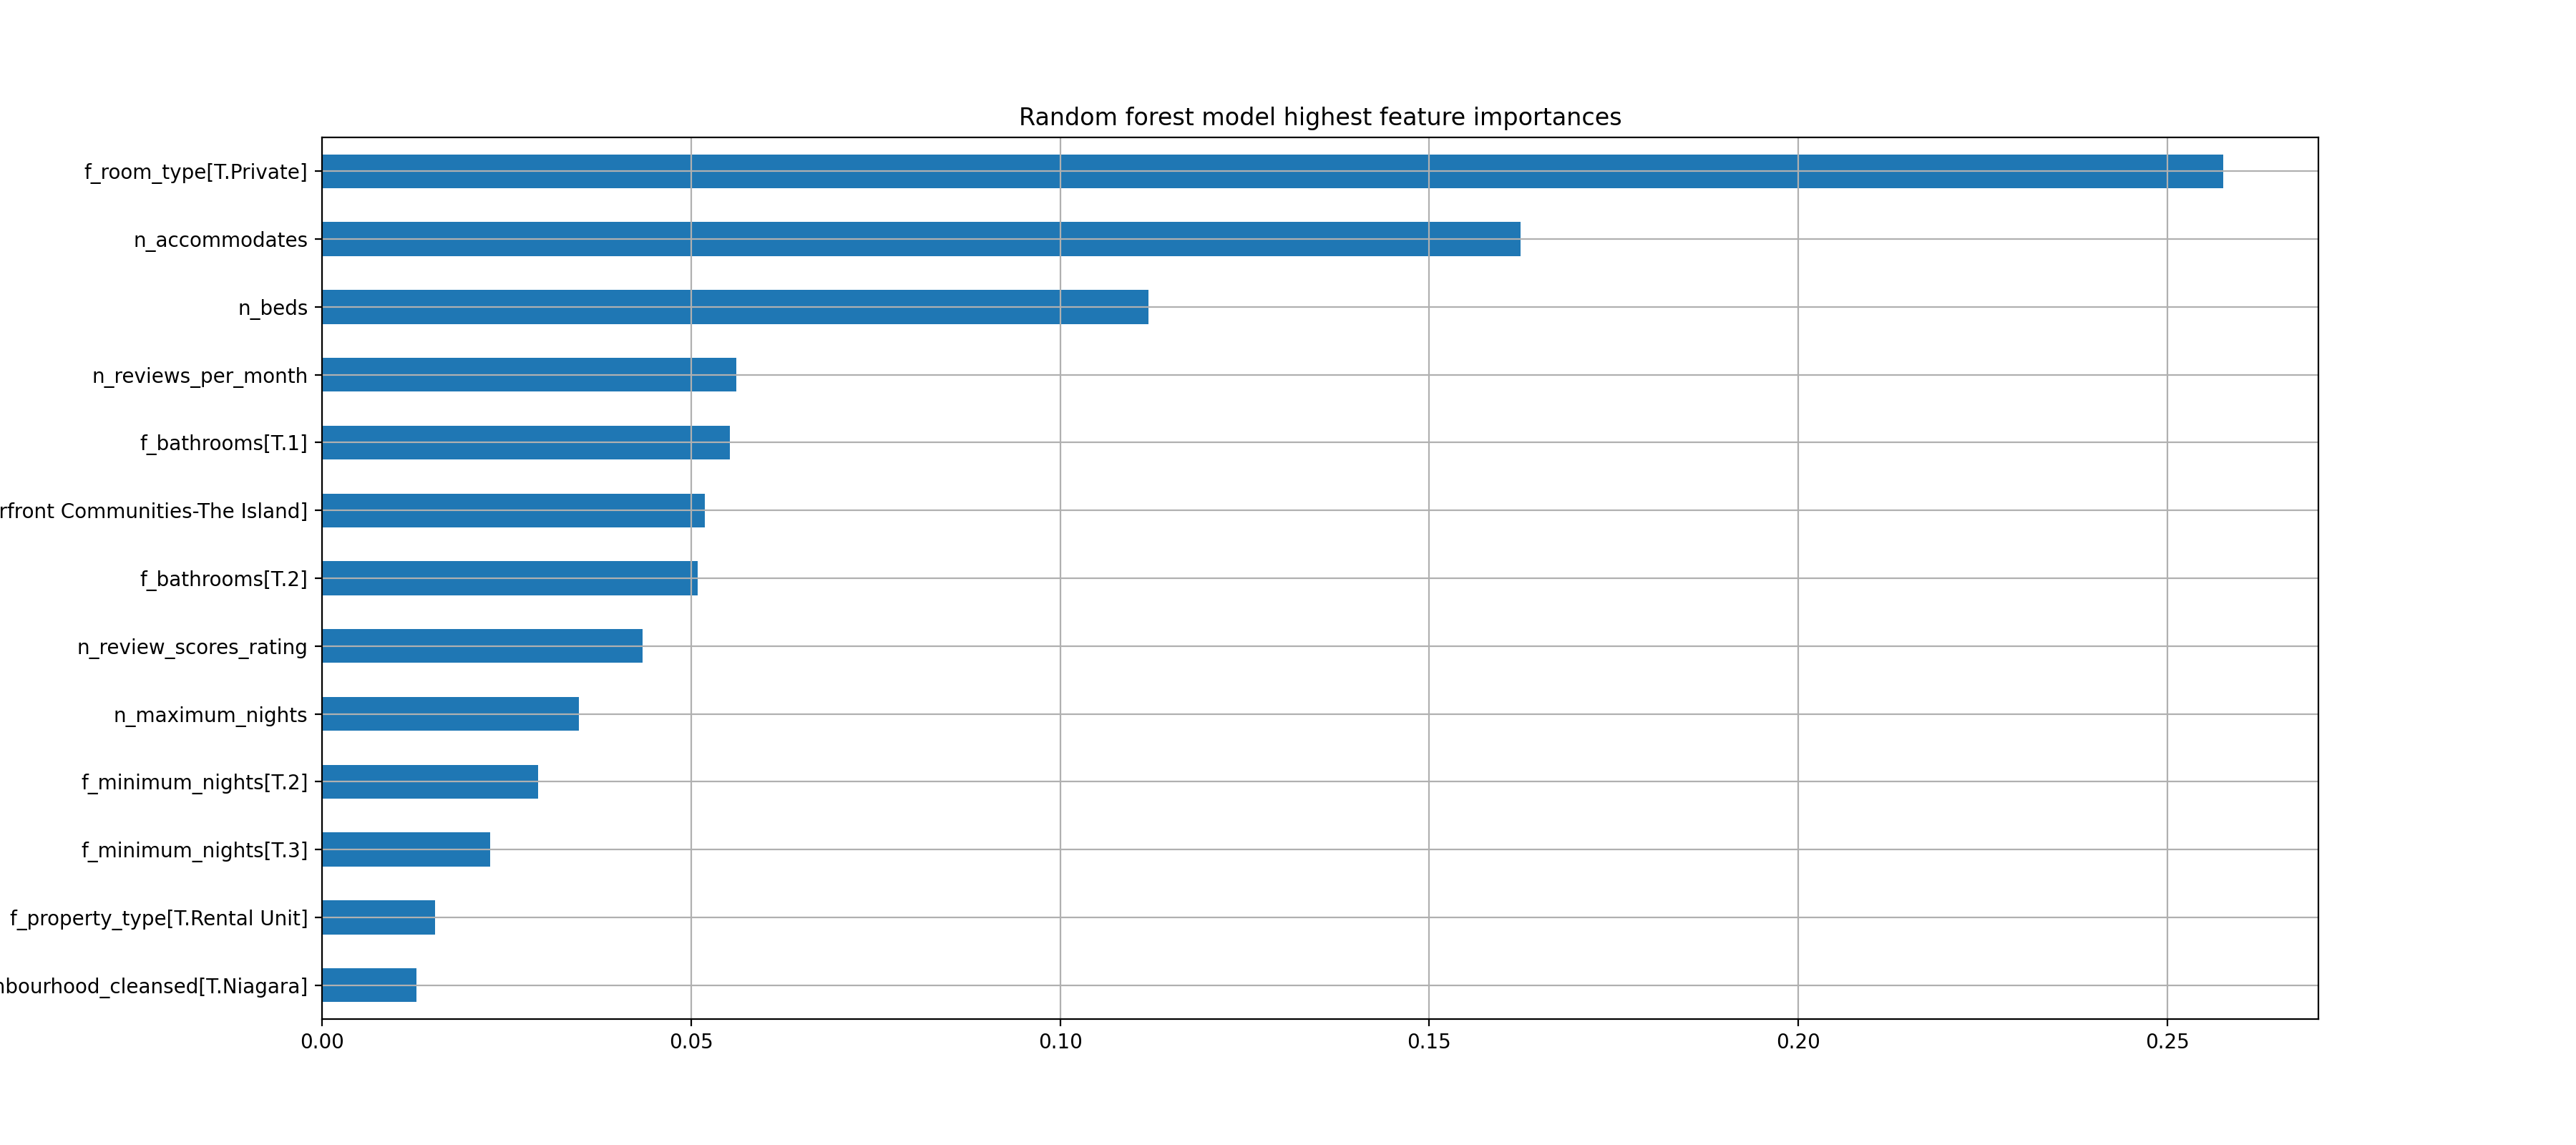

In [144]:
# Plotting feature importances with horizontal bar charts
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (18,8), grid = True, 
          title = 'Random forest model highest feature importances', 
          ylabel = 'Variables', legend = False
         );
plt.show()

----------------------------------------------------------------------------------------------------------------
# Diagnostics

----------------------------------------------------------------------------------------------------------------


In [147]:
# Comparing the RMSE values of all models
df_rmse = pd.DataFrame({'Model':
                        ['OLS', 'LASSO', 'RandomForest'],
                        'RMSE': [50.559, 53.443, 52.39]})

In [148]:
df_rmse

,Model,RMSE
0,OLS,50.559
1,LASSO,53.443
2,RandomForest,52.390


#### Creating an OLS linear regression with the variables obtaining the highest feature importance values

In [111]:
# Creating the regression
reg5 = smf.ols(formula="usd_price_day~f_room_type + n_accommodates + n_beds", data=data).fit(cov_type="HC1")
reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          usd_price_day   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     1306.
Date:                Sat, 10 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:32:09   Log-Likelihood:                -56247.
No. Observations:               10376   AIC:                         1.125e+05
Df Residuals:                   10371   BIC:                         1.125e+05
Df Model:                           4                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 97.8792      1.738     56.328      0.000      94.473     101.285
f_room_type[T.Private]   -49.9598      1.156    -43.215      0.000     -52.226     -47.694
f_room_type[T.Shared]    -57.3206      9.244     -6.201      0.000     -75.438     -39.203
n_accommodates            14.6092      0.678     21.544      0.000      13.280      15.938
n_beds                     2.4155      0.929      2.600      0.009       0.595       4.236
==============================================================================
Omnibus:                      661.072   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              794.560
Skew:                           0.651   Prob(JB):                    2.91e-173
Kurtosis:                       3.376   Cond. No.                         62.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [112]:
# Comparing the first linear regression with reg5, the "optimal" regression model
sg = stargazer.Stargazer([reg1, reg5])

# Setting the covariate order
covariate_order = ["f_room_type[T.Private]", "f_room_type[T.Shared]",
                   "n_accommodates", "n_beds", "Intercept"]
sg.covariate_order(covariate_order)

sg.rename_covariates({"n_accommodates": "Accommodates", 
                      "f_room_type[T.Private]": "Private Room Type", 
                      "f_room_type[T.Shared]": "Shared Room Type", 
                      "n_beds" : "Beds",
                      "Intercept": "Constant"})

# Adding RMSE for measurement in the full sample for each model
rmse_values = [round(rmse(x.fittedvalues, data.usd_price_day), 3) for x in [reg1, reg5]]
sg.add_line('RMSE', rmse_values, location=stargazer.LineLocation.FOOTER_BOTTOM)

# Adding BIC for measurement in the full sample for each model
bic = [round(x.bic, 2) for x in [reg1, reg5]]
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)

sg

Interestingly, regressing the price on the variables with the highest feature importance yielded worse results than expected. Comparing the RMSE value of the most complex linear regression (50.559) and this regression (54.705) shows us a significant difference. This indicates that while certain features may have high importance in RandomForest, their predictive power may not translate well to other types of models.